In [1]:
#prerequites 
import numpy as np
import pandas as pd
import scipy.stats as sp
from scipy.stats import f
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
import matplotlib.pyplot as plt
import sklearn as sk
import os

In [2]:
class Hypothesis: # #Store the regression model and data
    """
    Initialize base hypothesis class.
    Stores the model and converts x, y to numpy arrays.
    """
    def __init__(self,model,x,y):
        self.model = model
        self.x = np.asarray(x)    # Convert x to numpy array
        self.y = np.asarray(y)    # Convert y to numpy array
        self.x_cons = sm.add_constant(self.x)  # Add constant column for statsmodels OLS

In [3]:
"""
Utility Functions for AssumpHelp
"""
import numpy as np
import scipy.stats as sp
from scipy.stats import f
import statsmodels.api as sm
import matplotlib.pyplot as plt
import sklearn as sk
import os

def prepare_vars(model, x, y):
    """
    Prepares fitted and residual values
    """ 
    if not hasattr(model, "predict"):
        raise ValueError("Model must be a fitted regression model.")
        
    y_predictions = model.predict(x)  # fitted values
    residuals = y - y_predictions
    
    return y_predictions, residuals

def interpret_pval(pval, assump):
    if pval > 0.05:
        return f"If alpha = 0.05 and p-value > 0.05: Assumption of {assump.capitalize()} is NOT VIOLATED.\n"
    else:
        return f"If alpha = 0.05 and p-value > 0.05: Assumption of {assump.capitalize()} is VIOLATED.\n"

def plot_assump(fitted, residuals,assumption):

    # Linearity: Residuals vs Fitted
    if assumption.lower() == "linearity":
        plt.figure(figsize=(8,6))
        plt.scatter(fitted, residuals, alpha=0.5)
        plt.xlabel("Fitted Values")
        plt.ylabel("Residuals")
        plt.title("Residuals vs Fitted Plot")
        plt.show()

    # Homoscedasticity: Scale-Location Plot
    elif assumption.lower() == "homoscedasticity":
        std_resid = residuals / np.std(residuals)
        plt.figure(figsize=(8,6))
        plt.scatter(fitted, np.sqrt(np.abs(std_resid)), alpha=0.5)
        plt.xlabel("Fitted Values")
        plt.ylabel("Sqrt(|Standardized Residuals|)")
        plt.title("Scale-Location Plot (Homoscedasticity Check)")
        plt.show()

    # Normality: Q-Q Plot
    elif assumption.lower() == "normality":
        sm.qqplot(residuals, line='s')
        plt.title("Q-Q Plot")
        plt.show()

    # Independence: 
    elif assumption.lower() == "independence":
        order = np.arange(1, len(residuals) + 1)
        plt.figure(figsize=(8, 6))
        plt.scatter(order, residuals, alpha=0.5)
        plt.xlabel("Observation Order")
        plt.ylabel("Residuals")
        plt.title("Residuals vs Order Plot")
        plt.show()

    else:
        raise ValueError("Invalid Assumption. Please double-check spelling.")

def interpret_dw(dw_stat):
    """
    For Durbin-Watson Stat Comparitson
    """
    if 1.5 <= dw_stat <= 2.5:
        return("DW statistic close to 2 indicates no autocorrelation assumption NOT VIOLATED.")
    elif 1.5 > dw_stat:
        return("DW statistic significantly less than 2 indicates positive autocorrelation VIOLATED.")
    elif dw_stat > 2.5:
        return("DW statistic significantly greater than 2 indicates negative autocorrelation VIOLATED.")


def load_output(path):
    with open(path, "r") as f:
        return f.read()

In [4]:
class Linearity(Hypothesis):
    """
    Linearity assumption checker using:
    - Ramsey RESET test
    - Residuals vs Fitted plot
    """
    def fit(self):
        # Assert that x and y have the same number of observations
        assert len(self.x) == len(self.y), "x and y must have the same number of observations"
        
        # Assert that x has at least one feature
        assert self.x.shape[0] > 0, "x must have at least one observation"
        assert self.x.shape[1] > 0, "x must have at least one feature"
        
        # Assert that y is not empty
        assert len(self.y) > 0, "y must not be empty"
        
        # Assert no NaN values
        assert not np.any(np.isnan(self.x)), "x contains NaN values"
        assert not np.any(np.isnan(self.y)), "y contains NaN values"
        
        # Assert no infinite values
        assert np.all(np.isfinite(self.x)), "x contains infinite values"
        assert np.all(np.isfinite(self.y)), "y contains infinite values"
        
        # Assert sufficient observations for regression
        n_obs = len(self.y)
        n_features = self.x.shape[1] + 1  # +1 for constant
        assert n_obs > n_features, f"Need more observations ({n_obs}) than features ({n_features}) for OLS"
        
        self.fitted_model = sm.OLS(self.y, self.x_cons).fit()
        self.fitted, self.residuals = prepare_vars(self.fitted_model, self.x_cons, self.y)
        
        # Assert fitted and residuals have correct shape
        assert self.fitted.shape == self.y.shape, f"fitted shape {self.fitted.shape} doesn't match y shape {self.y.shape}"
        assert self.residuals.shape == self.y.shape, f"residuals shape {self.residuals.shape} doesn't match y shape {self.y.shape}"
    
    def test_linearity(self):
        """
        Perform Ramsey RESET test for linearity.
        """
        self.fit()
        reset_model = sm.OLS(self.y, self.x_cons).fit()
        
        # Assert power parameter is valid
        power = 3
        assert power >= 2, "Power for RESET test must be at least 2"
        assert isinstance(power, int), "Power must be an integer"
        
        # Assert test_type is valid
        test_type = "fitted"
        assert test_type in ["fitted", "princomp", "regressor"], \
            f"test_type must be one of ['fitted', 'princomp', 'regressor'], got {test_type}"
        
        reset_result = linear_reset(reset_model, power=power, test_type=test_type)
        
        # Assert RESET test produced valid results
        assert hasattr(reset_result, 'statistic'), "RESET test result missing 'statistic' attribute"
        assert hasattr(reset_result, 'pvalue'), "RESET test result missing 'pvalue' attribute"
        assert reset_result.statistic >= 0, "F-statistic should be non-negative"
        assert 0 <= reset_result.pvalue <= 1, f"p-value must be between 0 and 1, got {reset_result.pvalue}"
        
        result_fstat, result_pval = reset_result.statistic, reset_result.pvalue
        
        print("RESET Test for Linearity")
        print(f"F-statistic: {result_fstat:.4f}      p-value: {result_pval:.4f}")
        print("\nInterpretation:\n")
        
        # Assert pval is numeric
        assert isinstance(result_pval, (int, float, np.number)), f"p-value must be numeric, got {type(result_pval)}"
        
        interpretation = interpret_pval(result_pval, "linearity")
        
        # Assert interpretation is a string
        assert isinstance(interpretation, str), f"interpretation must be a string, got {type(interpretation)}"
        assert len(interpretation) > 0, "interpretation string is empty"
        
        print("\n" + interpretation)
        
        # Store result for later use
        self.result = result_pval
        
        # Assert result attribute was created
        assert hasattr(self, 'result'), "result attribute should be created"
        assert self.result == result_pval, "Stored result doesn't match calculated p-value"
    
    def plot_linearity(self):
        """
        Plot linearity diagnostics.
        """
        # Assert fit() has been called or attributes exist
        assert hasattr(self, 'fitted'), "Must call fit() or test_linearity() before plot_linearity()"
        assert hasattr(self, 'residuals'), "Must call fit() or test_linearity() before plot_linearity()"
        
        # Assert fitted and residuals are numpy arrays
        assert isinstance(self.fitted, np.ndarray), f"fitted must be numpy array, got {type(self.fitted)}"
        assert isinstance(self.residuals, np.ndarray), f"residuals must be numpy array, got {type(self.residuals)}"
        
        # Assert same length
        assert len(self.fitted) == len(self.residuals), \
            f"fitted length ({len(self.fitted)}) doesn't match residuals length ({len(self.residuals)})"
        
        # Assert not empty
        assert len(self.fitted) > 0, "fitted array is empty"
        assert len(self.residuals) > 0, "residuals array is empty"
        
        # Assert no NaN values in data to plot
        assert not np.any(np.isnan(self.fitted)), "fitted contains NaN values"
        assert not np.any(np.isnan(self.residuals)), "residuals contains NaN values"
        
        plot_assump(self.fitted, self.residuals, "linearity")
        
        print("Interpretation Guide:\n")
        
        # Define expected filename
        filename = "linplot_interpretation_guide.txt"
        
        # Assert file exists or can be created
        try:
            guide_text = load_output(filename)
            
            # Assert loaded text is a string
            assert isinstance(guide_text, str), f"Loaded guide must be a string, got {type(guide_text)}"
            
            # Assert guide is not empty (or at least has some content)
            assert len(guide_text.strip()) > 0, "Interpretation guide file is empty"
            
            # Assert guide contains relevant keywords
            assert any(keyword in guide_text.lower() for keyword in 
                      ["linearity", "residuals", "fitted", "plot", "interpretation"]), \
                "Interpretation guide doesn't contain expected keywords"
                
        except FileNotFoundError:
            # If file doesn't exist, create a default guide
            print(f"Warning: {filename} not found. Using default interpretation guide.")
            guide_text = """Linearity Plot (Residuals vs Fitted Values)

            If the plot shows a random scatter of points around the horizontal axis with no clear curve, the relationship between the predictors and the outcome is linear.
            > The assumption of linearity is NOT VIOLATED.

            If the plot shows a curve or systematic pattern in the scatter of points, the relationship between the predictors and the outcome is not linear.
            > The assumption of linearity is VIOLATED.

            Always double check with the RESET test."""
        
        print(guide_text)
        
        # Assert something was printed
        # (We can't easily assert print was called, but we ensure guide_text exists)
        assert 'guide_text' in locals() or 'guide_text' in globals(), "guide_text variable should exist"

RESET Test for Linearity
F-statistic: 0.6842      p-value: 0.7103

Interpretation:


If alpha = 0.05 and p-value > 0.05: Assumption of Linearity is NOT VIOLATED.



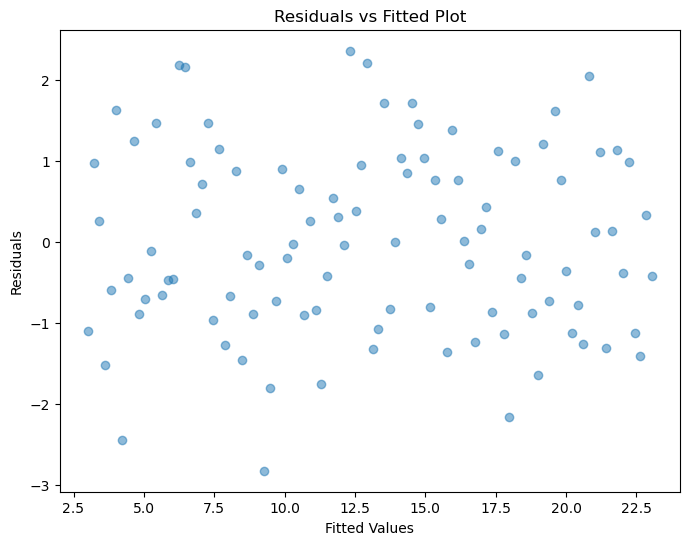

Interpretation Guide:



FileNotFoundError: [Errno 2] No such file or directory: 'linplot_interpretation_guide.txt'

In [6]:
if __name__ == "__main__":
    # Create synthetic data
    np.random.seed(123)
    x = np.linspace(0, 10, 100)
    y = 3 + 2*x + np.random.normal(0, 1, size=x.shape)  # linear relationship

    # Initialize class
    lin_checker = Linearity(None, x.reshape(-1,1), y)
    
    # Run RESET test
    lin_checker.test_linearity()
    
    # Plot Residuals vs Fitted
    lin_checker.plot_linearity()

In [ ]:
class Homoscedasticity(Hypothesis):
    """
    Homoscedasticity checker using:
    - Breusch-Pagan test
    - Scale-Location plot
    """
    def fit(self):
        # Assert that x and y have the same number of observations
        assert len(self.x) == len(self.y), "x and y must have the same number of observations"
        
        # Assert that x has at least one feature
        assert self.x.shape[0] > 0, "x must have at least one observation"
        assert self.x.shape[1] > 0, "x must have at least one feature"
        
        # Assert that y is not empty
        assert len(self.y) > 0, "y must not be empty"
        
        # Assert no NaN values
        assert not np.any(np.isnan(self.x)), "x contains NaN values"
        assert not np.any(np.isnan(self.y)), "y contains NaN values"
        
        # Assert no infinite values
        assert np.all(np.isfinite(self.x)), "x contains infinite values"
        assert np.all(np.isfinite(self.y)), "y contains infinite values"
        
        # Assert sufficient observations for regression
        n_obs = len(self.y)
        n_features = self.x.shape[1] + 1  # +1 for constant
        assert n_obs > n_features, f"Need more observations ({n_obs}) than features ({n_features}) for OLS"
        
        self.fitted_model = sm.OLS(self.y, self.x_cons).fit()
        self.fitted, self.residuals = prepare_vars(self.fitted_model, self.x_cons, self.y)
        
        # Assert fitted and residuals have correct shape
        assert self.fitted.shape == self.y.shape, f"fitted shape {self.fitted.shape} doesn't match y shape {self.y.shape}"
        assert self.residuals.shape == self.y.shape, f"residuals shape {self.residuals.shape} doesn't match y shape {self.y.shape}"
   
    def test_homoscedasticity(self):
        """
        Perform Breusch-Pagan test.
        """
        self.fit()
        
        # Assert residuals exist and are valid
        assert hasattr(self, 'residuals'), "residuals attribute not found"
        assert isinstance(self.residuals, np.ndarray), f"residuals must be numpy array, got {type(self.residuals)}"
        assert len(self.residuals) > 0, "residuals array is empty"
        assert not np.any(np.isnan(self.residuals)), "residuals contains NaN values"
        assert not np.any(np.isinf(self.residuals)), "residuals contains infinite values"
        
        # Assert x_cons exists and is valid
        assert hasattr(self, 'x_cons'), "x_cons attribute not found"
        assert isinstance(self.x_cons, np.ndarray), f"x_cons must be numpy array, got {type(self.x_cons)}"
        assert self.x_cons.shape[0] == len(self.residuals), f"x_cons rows ({self.x_cons.shape[0]}) must match residuals length ({len(self.residuals)})"
        
        # Assert x_cons has full rank for Breusch-Pagan test
        rank = np.linalg.matrix_rank(self.x_cons)
        assert rank == self.x_cons.shape[1], f"x_cons must have full rank for Breusch-Pagan test. Rank: {rank}, Columns: {self.x_cons.shape[1]}"
        
        bp_test = het_breuschpagan(self.residuals, self.x_cons)
        
        # Assert Breusch-Pagan test returns valid tuple
        assert isinstance(bp_test, tuple), f"het_breuschpagan should return tuple, got {type(bp_test)}"
        assert len(bp_test) == 4, f"het_breuschpagan should return 4 values, got {len(bp_test)}"
        
        bp_stat, bp_pval, _, _ = bp_test
        
        # Assert test statistic is valid
        assert isinstance(bp_stat, (int, float, np.number)), f"BP-statistic must be numeric, got {type(bp_stat)}"
        assert bp_stat >= 0, f"BP-statistic should be non-negative, got {bp_stat}"
        
        # Assert p-value is valid
        assert isinstance(bp_pval, (int, float, np.number)), f"p-value must be numeric, got {type(bp_pval)}"
        assert 0 <= bp_pval <= 1, f"p-value must be between 0 and 1, got {bp_pval}"
        
        self.result = bp_pval
        
        # Assert result attribute was created
        assert hasattr(self, 'result'), "result attribute should be created"
        assert self.result == bp_pval, "Stored result doesn't match calculated p-value"
        
        print("Breusch-Pagan Test for Homoscedasticity")
        print(f"BP-statistic: {bp_stat:.4f}      p-value: {bp_pval:.4f}")
        print("\nInterpretation:\n")
        
        # Assert pval is numeric before passing to interpret_pval
        assert isinstance(bp_pval, (int, float, np.number)), f"bp_pval must be numeric for interpret_pval, got {type(bp_pval)}"
        
        interpretation = interpret_pval(bp_pval, "homoscedasticity")
        
        # Assert interpretation is a string
        assert isinstance(interpretation, str), f"interpretation must be a string, got {type(interpretation)}"
        assert len(interpretation) > 0, "interpretation string is empty"
        
        print("\n" + interpretation)

    def plot_homoscedasticity(self):
        """
        Plot homoscedasticity diagnostics.
        """
        # Assert fit() has been called or attributes exist
        assert hasattr(self, 'fitted'), "Must call fit() or test_homoscedasticity() before plot_homoscedasticity()"
        assert hasattr(self, 'residuals'), "Must call fit() or test_homoscedasticity() before plot_homoscedasticity()"
        
        # Assert fitted and residuals are numpy arrays
        assert isinstance(self.fitted, np.ndarray), f"fitted must be numpy array, got {type(self.fitted)}"
        assert isinstance(self.residuals, np.ndarray), f"residuals must be numpy array, got {type(self.residuals)}"
        
        # Assert same length
        assert len(self.fitted) == len(self.residuals), \
            f"fitted length ({len(self.fitted)}) doesn't match residuals length ({len(self.residuals)})"
        
        # Assert not empty
        assert len(self.fitted) > 0, "fitted array is empty"
        assert len(self.residuals) > 0, "residuals array is empty"
        
        # Assert no NaN values in data to plot
        assert not np.any(np.isnan(self.fitted)), "fitted contains NaN values"
        assert not np.any(np.isnan(self.residuals)), "residuals contains NaN values"
        
        # Assert fitted values have variance (not all same value)
        assert np.std(self.fitted) > 1e-10, "fitted values have zero variance - cannot plot homoscedasticity"
        
        # Assert residuals have variance
        assert np.std(self.residuals) > 1e-10, "residuals have zero variance - cannot assess homoscedasticity"
        
        plot_assump(self.fitted, self.residuals, "homoscedasticity")
        
        print("Interpretation Guide:\n")
        
        # Define expected filename
        filename = "homplot_interpretation_guide.txt"
        
        # Assert file exists or can be created
        try:
            guide_text = load_output(filename)
            
            # Assert loaded text is a string
            assert isinstance(guide_text, str), f"Loaded guide must be a string, got {type(guide_text)}"
            
            # Assert guide is not empty (or at least has some content)
            assert len(guide_text.strip()) > 0, "Interpretation guide file is empty"
            
            # Assert guide contains relevant keywords for homoscedasticity
            assert any(keyword in guide_text.lower() for keyword in 
                      ["homoscedasticity", "heteroscedasticity", "constant variance", 
                       "residuals", "scale-location", "plot", "interpretation"]), \
                "Interpretation guide doesn't contain expected homoscedasticity keywords"
                
        except FileNotFoundError:
            # If file doesn't exist, create a default guide
            print(f"Warning: {filename} not found. Using default interpretation guide.")
            guide_text = """Homoscedasticity (Scale-Location Plot)

            If the plot shows points evenly spread along a horizontal line, the residuals have constant variance.
            > The assumption of homoscedasticity is NOT VIOLATED.

            If the plot shows a pattern, such as points spreading out or narrowing (e.g., funnel shape), the residuals do not have constant variance.
            > The assumption of homoscedasticity is VIOLATED.

            Always double check with the Breusch-Pagan test."""
        
        print(guide_text)
        
        # Assert something was printed
        # (We can't easily assert print was called, but we ensure guide_text exists)
        assert 'guide_text' in locals() or 'guide_text' in globals(), "guide_text variable should exist"

In [ ]:
class Normality(Hypothesis): 
    """
    Normality checker using:
    - Shapiro-Wilk test
    - Q-Q plot
    """
    def fit(self):
        # Assert that x and y have the same number of observations
        assert len(self.x) == len(self.y), "x and y must have the same number of observations"
        
        # Assert that x has at least one feature
        assert self.x.shape[0] > 0, "x must have at least one observation"
        assert self.x.shape[1] > 0, "x must have at least one feature"
        
        # Assert that y is not empty
        assert len(self.y) > 0, "y must not be empty"
        
        # Assert no NaN values
        assert not np.any(np.isnan(self.x)), "x contains NaN values"
        assert not np.any(np.isnan(self.y)), "y contains NaN values"
        
        # Assert no infinite values
        assert np.all(np.isfinite(self.x)), "x contains infinite values"
        assert np.all(np.isfinite(self.y)), "y contains infinite values"
        
        # Assert sufficient observations for regression
        n_obs = len(self.y)
        n_features = self.x.shape[1] + 1  # +1 for constant
        assert n_obs > n_features, f"Need more observations ({n_obs}) than features ({n_features}) for OLS"
        
        # Shapiro-Wilk test has sample size limits
        assert n_obs >= 3, "Shapiro-Wilk test requires at least 3 observations"
        assert n_obs <= 5000, "Shapiro-Wilk test is not recommended for n > 5000"
        
        self.fitted_model = sm.OLS(self.y, self.x_cons).fit()
        self.fitted, self.residuals = prepare_vars(self.fitted_model, self.x_cons, self.y)
        
        # Assert fitted and residuals have correct shape
        assert self.fitted.shape == self.y.shape, f"fitted shape {self.fitted.shape} doesn't match y shape {self.y.shape}"
        assert self.residuals.shape == self.y.shape, f"residuals shape {self.residuals.shape} doesn't match y shape {self.y.shape}"
   
    def test_normality(self):
        """
        Perform Shapiro-Wilk test.
        """
        self.fit()
        
        # Assert residuals exist and are valid for Shapiro-Wilk test
        assert hasattr(self, 'residuals'), "residuals attribute not found"
        assert isinstance(self.residuals, np.ndarray), f"residuals must be numpy array, got {type(self.residuals)}"
        
        # Shapiro-Wilk test requirements
        assert len(self.residuals) >= 3, "Shapiro-Wilk test requires at least 3 observations"
        assert len(self.residuals) <= 5000, "Shapiro-Wilk test is not recommended for n > 5000"
        
        # Check for constant residuals (all same value)
        residuals_std = np.std(self.residuals)
        assert residuals_std > 1e-10, "Residuals have zero variance - Shapiro-Wilk test invalid"
        
        # Check for NaN or infinite values
        assert not np.any(np.isnan(self.residuals)), "residuals contains NaN values - cannot perform Shapiro-Wilk test"
        assert not np.any(np.isinf(self.residuals)), "residuals contains infinite values - cannot perform Shapiro-Wilk test"
        
        # Check residuals are not all zeros
        assert not np.all(self.residuals == 0), "All residuals are zero - Shapiro-Wilk test invalid"
        
        shapiro_stat, shapiro_pval = sp.shapiro(self.residuals)
        
        # Assert Shapiro-Wilk test returned valid results
        assert isinstance(shapiro_stat, (int, float, np.number)), f"W-statistic must be numeric, got {type(shapiro_stat)}"
        assert 0 <= shapiro_stat <= 1, f"W-statistic must be between 0 and 1, got {shapiro_stat}"
        
        # W-statistic close to 1 indicates normality
        assert not np.isnan(shapiro_stat), "W-statistic is NaN"
        
        assert isinstance(shapiro_pval, (int, float, np.number)), f"p-value must be numeric, got {type(shapiro_pval)}"
        assert 0 <= shapiro_pval <= 1, f"p-value must be between 0 and 1, got {shapiro_pval}"
        assert not np.isnan(shapiro_pval), "p-value is NaN"
        
        self.result = shapiro_pval
        
        # Assert result attribute was created
        assert hasattr(self, 'result'), "result attribute should be created"
        assert self.result == shapiro_pval, "Stored result doesn't match calculated p-value"
        
        print("Shapiro-Wilk Test for Normality")
        print(f"W-statistic: {shapiro_stat:.4f}      p-value: {shapiro_pval:.4f}")
        print("\nInterpretation:\n")
        
        # Assert pval is numeric before passing to interpret_pval
        assert isinstance(shapiro_pval, (int, float, np.number)), f"shapiro_pval must be numeric for interpret_pval, got {type(shapiro_pval)}"
        
        interpretation = interpret_pval(shapiro_pval, "normality")
        
        # Assert interpretation is a string
        assert isinstance(interpretation, str), f"interpretation must be a string, got {type(interpretation)}"
        assert len(interpretation) > 0, "interpretation string is empty"
        
        # Assert interpretation mentions normality
        assert "normality" in interpretation.lower(), "interpretation should mention 'normality'"
        
        print("\n" + interpretation)
        
    
    def plot_normality(self):
        """
        Plot Q-Q plot.
        """
        # Assert fit() has been called or attributes exist
        assert hasattr(self, 'fitted'), "Must call fit() or test_normality() before plot_normality()"
        assert hasattr(self, 'residuals'), "Must call fit() or test_normality() before plot_normality()"
        
        # Assert fitted and residuals are numpy arrays
        assert isinstance(self.fitted, np.ndarray), f"fitted must be numpy array, got {type(self.fitted)}"
        assert isinstance(self.residuals, np.ndarray), f"residuals must be numpy array, got {type(self.residuals)}"
        
        # Assert same length
        assert len(self.fitted) == len(self.residuals), \
            f"fitted length ({len(self.fitted)}) doesn't match residuals length ({len(self.residuals)})"
        
        # Assert not empty
        assert len(self.fitted) > 0, "fitted array is empty"
        assert len(self.residuals) > 0, "residuals array is empty"
        
        # Minimum observations for meaningful Q-Q plot
        assert len(self.residuals) >= 5, "Q-Q plot requires at least 5 observations for meaningful interpretation"
        
        # Assert no NaN values in data to plot
        assert not np.any(np.isnan(self.fitted)), "fitted contains NaN values"
        assert not np.any(np.isnan(self.residuals)), "residuals contains NaN values"
        
        # Check residuals have some variance for Q-Q plot
        residuals_std = np.std(self.residuals)
        assert residuals_std > 1e-10, "Residuals have zero variance - Q-Q plot invalid"
        
        # Check residuals are not all zeros
        assert not np.all(self.residuals == 0), "All residuals are zero - Q-Q plot invalid"
        
        plot_assump(self.fitted, self.residuals, "normality")
        
        print("Interpretation Guide:\n")
        
        # Define expected filename
        filename = "normplot_interpretation_guide.txt"
        
        # Assert file exists or can be created
        try:
            guide_text = load_output(filename)
            
            # Assert loaded text is a string
            assert isinstance(guide_text, str), f"Loaded guide must be a string, got {type(guide_text)}"
            
            # Assert guide is not empty (or at least has some content)
            assert len(guide_text.strip()) > 0, "Interpretation guide file is empty"
            
            # Assert guide contains relevant keywords for normality
            assert any(keyword in guide_text.lower() for keyword in 
                      ["normality", "qq plot", "q-q", "normal", "residuals", 
                       "straight line", "diagonal", "interpretation"]), \
                "Interpretation guide doesn't contain expected normality keywords"
                
        except FileNotFoundError:
            # If file doesn't exist, create a default guide
            print(f"Warning: {filename} not found. Using default interpretation guide.")
            guide_text = """Normality (Q-Q Plot)

            If the points fall approximately along the straight diagonal line, the residuals are normally distributed.
            > The assumption of normality is NOT VIOLATED.

            If the points systematically deviate from the straight diagonal line (e.g., S-shape, curved pattern), the residuals are not normally distributed.
            > The assumption of normality is VIOLATED.

            Always double check with the Shapiro-Wilk test."""
        
        print(guide_text)
        
        # Assert something was printed
        # (We can't easily assert print was called, but we ensure guide_text exists)
        assert 'guide_text' in locals() or 'guide_text' in globals(), "guide_text variable should exist"


In [8]:
class Independence(Hypothesis):  
    """
    Independence checker using:
    - Durbin-Watson statistic
    - Residuals vs Order plot
    """
    def fit(self):
        # Assert that x and y have the same number of observations
        assert len(self.x) == len(self.y), "x and y must have the same number of observations"
        
        # Assert that x has at least one feature
        assert self.x.shape[0] > 0, "x must have at least one observation"
        assert self.x.shape[1] > 0, "x must have at least one feature"
        
        # Assert that y is not empty
        assert len(self.y) > 0, "y must not be empty"
        
        # Assert no NaN values
        assert not np.any(np.isnan(self.x)), "x contains NaN values"
        assert not np.any(np.isnan(self.y)), "y contains NaN values"
        
        # Assert no infinite values
        assert np.all(np.isfinite(self.x)), "x contains infinite values"
        assert np.all(np.isfinite(self.y)), "y contains infinite values"
        
        # Assert sufficient observations for regression
        n_obs = len(self.y)
        n_features = self.x.shape[1] + 1  # +1 for constant
        assert n_obs > n_features, f"Need more observations ({n_obs}) than features ({n_features}) for OLS"
        
        # Durbin-Watson requires at least 3 observations for meaningful test
        assert n_obs >= 3, "Durbin-Watson test requires at least 3 observations"
        
        self.fitted_model = sm.OLS(self.y, self.x_cons).fit()
        self.fitted, self.residuals = prepare_vars(self.fitted_model, self.x_cons, self.y)
        
        # Assert fitted and residuals have correct shape
        assert self.fitted.shape == self.y.shape, f"fitted shape {self.fitted.shape} doesn't match y shape {self.y.shape}"
        assert self.residuals.shape == self.y.shape, f"residuals shape {self.residuals.shape} doesn't match y shape {self.y.shape}"
        
    def test_independence(self):
        """
        Perform Durbin-Watson autocorrelation test.
        """
        self.fit()
        
        # Assert residuals exist and are valid
        assert hasattr(self, 'residuals'), "residuals attribute not found"
        assert isinstance(self.residuals, np.ndarray), f"residuals must be numpy array, got {type(self.residuals)}"
        
        # Durbin-Watson test requirements
        assert len(self.residuals) >= 3, "Durbin-Watson test requires at least 3 observations"
        
        # Check for constant residuals (all same value)
        residuals_std = np.std(self.residuals)
        assert residuals_std > 1e-10, "Residuals have zero variance - Durbin-Watson test invalid"
        
        # Check residuals are not all zeros
        assert not np.all(self.residuals == 0), "All residuals are zero - Durbin-Watson test invalid"
        
        # Check for NaN or infinite values
        assert not np.any(np.isnan(self.residuals)), "residuals contains NaN values - cannot perform Durbin-Watson test"
        assert not np.any(np.isinf(self.residuals)), "residuals contains infinite values - cannot perform Durbin-Watson test"
        
        dw_stat = durbin_watson(self.residuals)
        
        # Assert Durbin-Watson statistic is valid
        assert isinstance(dw_stat, (int, float, np.number)), f"DW-statistic must be numeric, got {type(dw_stat)}"
        assert not np.isnan(dw_stat), "DW-statistic is NaN"
        assert not np.isinf(dw_stat), "DW-statistic is infinite"
        
        # Durbin-Watson statistic range is 0 to 4
        assert 0 <= dw_stat <= 4, f"DW-statistic must be between 0 and 4, got {dw_stat}"
        
        self.result = dw_stat
        
        # Assert result attribute was created
        assert hasattr(self, 'result'), "result attribute should be created"
        assert self.result == dw_stat, "Stored result doesn't match calculated DW-statistic"
        
        print("Durbin-Watson Test for Independence")
        print(f"DW-statistic: {dw_stat:.4f}")
        print("\nInterpretation:\n")
        
        # Assert dw_stat is valid before passing to interpret_dw
        assert isinstance(dw_stat, (int, float, np.number)), f"dw_stat must be numeric for interpret_dw, got {type(dw_stat)}"
        assert 0 <= dw_stat <= 4, f"dw_stat must be between 0 and 4 for interpret_dw, got {dw_stat}"
        
        interpretation = interpret_dw(dw_stat)
        
        # Assert interpretation is a string
        assert isinstance(interpretation, str), f"interpretation must be a string, got {type(interpretation)}"
        assert len(interpretation) > 0, "interpretation string is empty"
        
        # Assert interpretation mentions independence/autocorrelation
        assert any(keyword in interpretation.lower() for keyword in 
                  ["autocorrelation", "independence", "dw", "durbin", "watson"]), \
            "interpretation should mention autocorrelation or independence"
        
        print("\n" + interpretation)
   
    def plot_independence(self):
        """
        Plot residuals vs observation order.
        """
        # Assert fit() has been called or attributes exist
        assert hasattr(self, 'fitted'), "Must call fit() or test_independence() before plot_independence()"
        assert hasattr(self, 'residuals'), "Must call fit() or test_independence() before plot_independence()"
        
        # Assert fitted and residuals are numpy arrays
        assert isinstance(self.fitted, np.ndarray), f"fitted must be numpy array, got {type(self.fitted)}"
        assert isinstance(self.residuals, np.ndarray), f"residuals must be numpy array, got {type(self.residuals)}"
        
        # Assert same length
        assert len(self.fitted) == len(self.residuals), \
            f"fitted length ({len(self.fitted)}) doesn't match residuals length ({len(self.residuals)})"
        
        # Assert not empty
        assert len(self.fitted) > 0, "fitted array is empty"
        assert len(self.residuals) > 0, "residuals array is empty"
        
        # Minimum observations for meaningful independence plot
        assert len(self.residuals) >= 3, "Independence plot requires at least 3 observations"
        
        # Assert no NaN values in data to plot
        assert not np.any(np.isnan(self.fitted)), "fitted contains NaN values"
        assert not np.any(np.isnan(self.residuals)), "residuals contains NaN values"
        
        # Check residuals have some variance
        residuals_std = np.std(self.residuals)
        assert residuals_std > 1e-10, "Residuals have zero variance - independence plot invalid"
        
        # Check residuals are not all zeros
        assert not np.all(self.residuals == 0), "All residuals are zero - independence plot invalid"
        
        # For time series/independence check, we need ordered data
        # Check if we have time-based data or can infer order
        if hasattr(self, 'time_index') and self.time_index is not None:
            assert len(self.time_index) == len(self.residuals), \
                f"time_index length ({len(self.time_index)}) doesn't match residuals length ({len(self.residuals)})"
            # Check time index is sorted
            assert np.all(np.diff(self.time_index) >= 0), "time_index must be sorted in ascending order"
        
        plot_assump(self.fitted, self.residuals, "independence")
        
        print("\nInterpretation:\n")
        
        # Define expected filename
        filename = "indepplot_interpretation_guide.txt"
        
        # Assert file exists or can be created
        try:
            guide_text = load_output(filename)
            
            # Assert loaded text is a string
            assert isinstance(guide_text, str), f"Loaded guide must be a string, got {type(guide_text)}"
            
            # Assert guide is not empty (or at least has some content)
            assert len(guide_text.strip()) > 0, "Interpretation guide file is empty"
            
            # Assert guide contains relevant keywords for independence
            assert any(keyword in guide_text.lower() for keyword in 
                      ["independence", "autocorrelation", "time", "order", "pattern", 
                       "random", "residuals", "plot", "interpretation"]), \
                "Interpretation guide doesn't contain expected independence keywords"
                
        except FileNotFoundError:
            # If file doesn't exist, create a default guide
            print(f"Warning: {filename} not found. Using default interpretation guide.")
            guide_text = """Independence (Residuals vs Order Plot)

            If the plot shows a random scatter of points with no discernible pattern, the residuals are independent.
            > The assumption of independence is NOT VIOLATED.

            If the plot shows systematic patterns (e.g., upward/downward trends, cyclical patterns, clustering), 
            the residuals are not independent (autocorrelation present).
            > The assumption of independence is VIOLATED.

            Always double check with the Durbin-Watson test."""
        
        print(guide_text)
        
        # Assert something was printed
        # (We can't easily assert print was called, but we ensure guide_text exists)
        assert 'guide_text' in locals() or 'guide_text' in globals(), "guide_text variable should exist"
        
        # Optional: Add time_index attribute if needed
        if not hasattr(self, 'time_index'):
            self.time_index = np.arange(len(self.residuals))

In [ ]:
import numpy as np
import statsmodels.api as sm

# Example linear data
np.random.seed(123)
x = np.linspace(0, 10, 100)
y = 3 + 2*x + np.random.normal(0, 1, size=x.shape)
X = sm.add_constant(x)  # statsmodels needs constant for OLS

# Fit OLS model
model = sm.OLS(y, X).fit()

# Homoscedasticity check
hom = Homoscedasticity(model, x.reshape(-1,1), y)
hom.test_homoscedasticity()
hom.plot_homoscedasticity()

# Normality check
norm = Normality(model, x.reshape(-1,1), y)
norm.test_normality()
norm.plot_normality()

# Independence check
indep = Independence(model, x.reshape(-1,1), y)
indep.test_independence()
indep.plot_independence()
